In [2]:
import pandas as pd
import numpy as np

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE

In [4]:
from google.colab import files
uploaded = files.upload()

Saving ODF_Fire_Occurrence_Data_2000-2022.csv to ODF_Fire_Occurrence_Data_2000-2022.csv


In [5]:
df = pd.read_csv("ODF_Fire_Occurrence_Data_2000-2022.csv")
df.head()

,Serial,FireCategory,FireYear,Area,DistrictName,UnitName,FullFireNumber,FireName,Size_class,EstTotalAcres,...,Industrial_Restriction,Ign_DateTime,ReportDateTime,Discover_DateTime,Control_DateTime,CreationDate,ModifiedDate,DistrictCode,UnitCode,DistFireNumber
0,102649,STAT,2015,EOA,Klamath-Lake,Klamath,15-981082-16,Bass 497,B,3.20,...,Does Not Apply - Eastern OR,09/02/2015 05:00:00 PM,09/02/2015 05:05:00 PM,09/02/2015 05:00:00 PM,09/02/2015 11:00:00 PM,09/05/2015 12:00:00 AM,10/13/2015 08:39:00 AM,98,981,082
1,131239,STAT,2022,EOA,Walker Range - WRFPA,Crescent,22-991220-23,Hay Fire,A,NaN,...,NaN,NaN,08/16/2022 06:56:00 PM,NaN,NaN,08/18/2022 12:00:00 AM,08/18/2022 09:11:00 AM,99,991,220
2,58256,STAT,2000,EOA,Central Oregon,John Day,00-952011-01,Slick Ear #2,B,0.75,...,Does Not Apply - Eastern OR,07/18/2000 07:00:00 PM,07/19/2000 01:20:00 PM,07/19/2000 01:15:00 PM,07/20/2000 12:50:00 AM,07/20/2000 09:13:00 AM,11/14/2000 09:16:00 AM,95,952,011
3,59312,STAT,2000,EOA,Northeast Oregon,La Grande,00-971024-01,Woodley,C,80.00,...,Does Not Apply - Eastern OR,08/24/2000 05:30:00 AM,08/24/2000 01:07:00 PM,08/24/2000 01:07:00 PM,09/01/2000 09:30:00 PM,08/29/2000 03:59:00 PM,12/21/2000 04:22:00 PM,97,971,024
4,61657,STAT,2001,SOA,Southwest Oregon,Grants Pass,01-712133-02,QUEENS BRANCH,A,0.10,...,Lvl 3 Restricted Shutdown,08/10/2001 05:40:00 PM,08/10/2001 05:47:00 PM,08/10/2001 05:45:00 PM,08/10/2001 06:30:00 PM,08/10/2001 06:42:00 PM,08/17/2001 11:45:00 AM,71,712,133


In [48]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Drop rows with missing critical data
df = df.dropna(subset=['GeneralCause', 'Lat_DD', 'Long_DD', 'Size_class', 'Ign_DateTime'])

# Convert datetime
df['Ign_DateTime'] = pd.to_datetime(df['Ign_DateTime'], errors='coerce')
df = df.dropna(subset=['Ign_DateTime'])

# Extract useful datetime features
df['Month'] = df['Ign_DateTime'].dt.month
df['Hour'] = df['Ign_DateTime'].dt.hour

# Encode categorical features
le_size = LabelEncoder()
le_cause = LabelEncoder()
le_human = LabelEncoder()

df['Size_class_encoded'] = le_size.fit_transform(df['Size_class'])
df['FireCauseEncoded'] = le_cause.fit_transform(df['GeneralCause'])
df['HumanOrLightning_encoded'] = le_human.fit_transform(df['HumanOrLightning'].astype(str))

# Check cleaned data
print("Preprocessed data sample:")
display(df[['Lat_DD', 'Long_DD', 'GeneralCause', 'FireCauseEncoded', 'Size_class', 'Size_class_encoded', 'Month', 'Hour']].head())

Preprocessed data sample:


,Lat_DD,Long_DD,GeneralCause,FireCauseEncoded,Size_class,Size_class_encoded,Month,Hour
0,42.13361,-122.04083,Under Invest,9,B,1,9,17
2,44.91519,-119.28863,Lightning,4,B,1,7,19
3,45.08509,-118.33440,Lightning,4,C,2,8,5
4,42.53671,-123.21215,Smoking,8,A,0,8,17
5,43.45583,-122.74889,Lightning,4,A,0,8,18


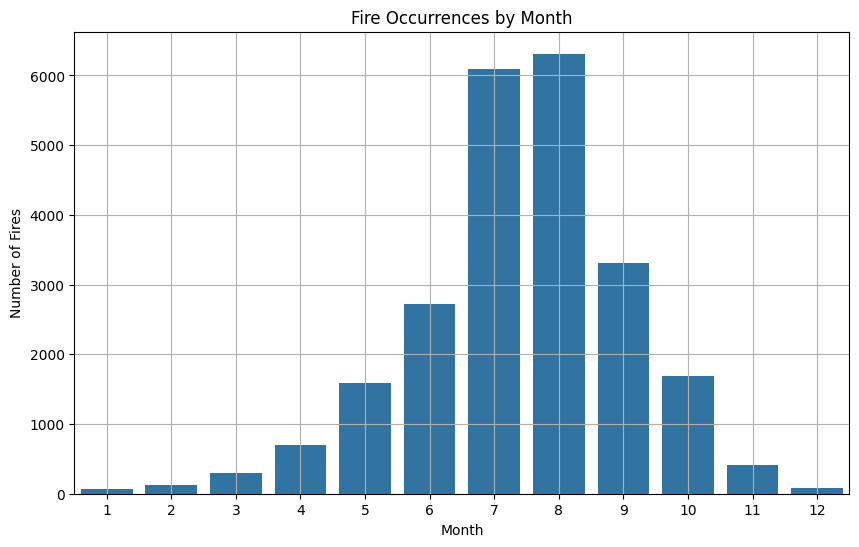

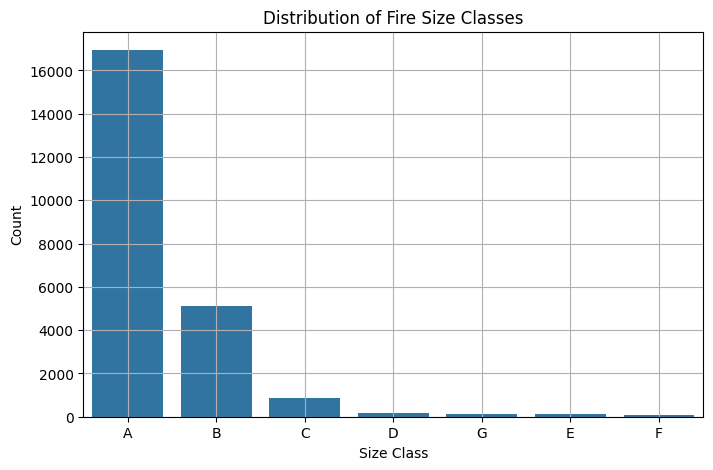

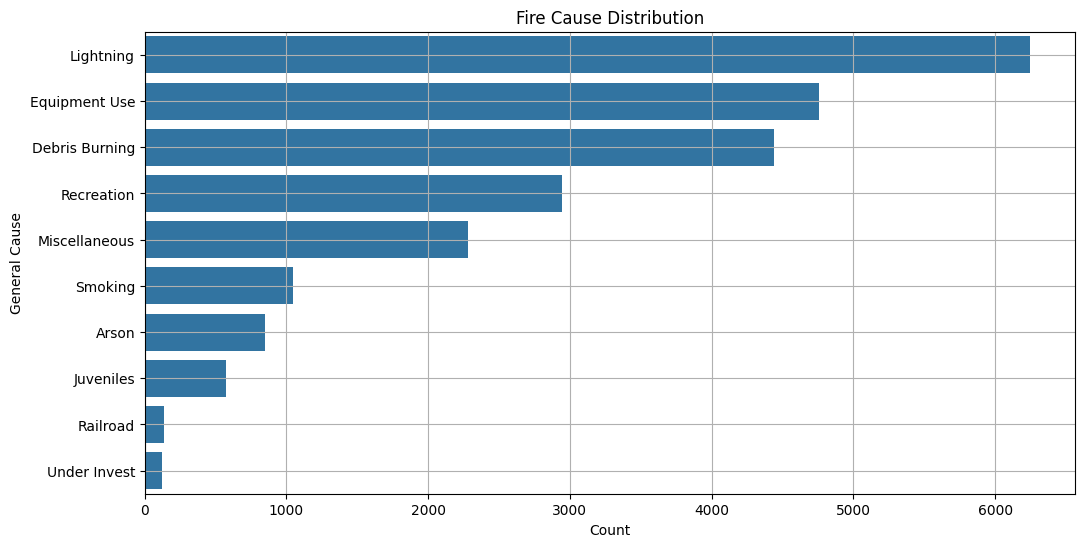

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

# 🔹 Fire Occurrences by Month
plt.figure(figsize=(10,6))
sns.countplot(x='Month', data=df, order=sorted(df['Month'].unique()))
plt.title('Fire Occurrences by Month')
plt.xlabel('Month')
plt.ylabel('Number of Fires')
plt.grid(True)
plt.show()

# 🔹 Size Class Distribution
plt.figure(figsize=(8,5))
sns.countplot(x='Size_class', data=df, order=df['Size_class'].value_counts().index)
plt.title('Distribution of Fire Size Classes')
plt.xlabel('Size Class')
plt.ylabel('Count')
plt.grid(True)
plt.show()

# 🔹 Fire Causes Distribution
plt.figure(figsize=(12,6))
sns.countplot(y='GeneralCause', data=df, order=df['GeneralCause'].value_counts().index)
plt.title('Fire Cause Distribution')
plt.xlabel('Count')
plt.ylabel('General Cause')
plt.grid(True)
plt.show()


<Axes: title={'center': 'Wildfire Occurrences per Year'}, xlabel='FireYear'>

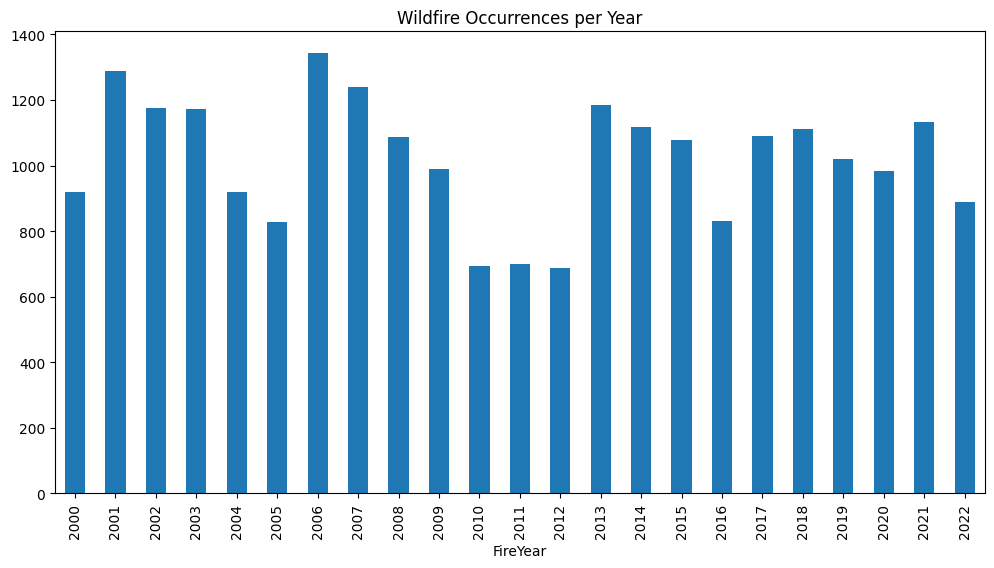

In [6]:
wildfire_per_year = df.groupby('FireYear').size()
wildfire_per_year.plot(kind='bar', figsize=(12,6), title='Wildfire Occurrences per Year')


<Axes: title={'center': 'Top 10 Districts by Wildfire Occurrence'}, ylabel='DistrictName'>

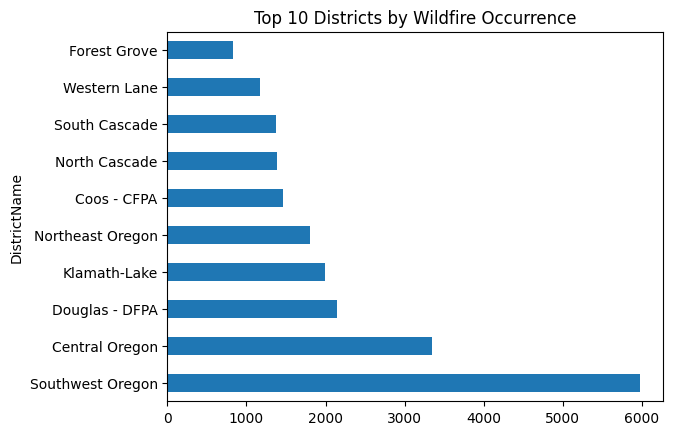

In [7]:
top_districts = df['DistrictName'].value_counts().head(10)
top_districts.plot(kind='barh', title='Top 10 Districts by Wildfire Occurrence')


/tmp/ipython-input-9-1271946784.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fires_per_year.index, y=fires_per_year.values, palette="flare")


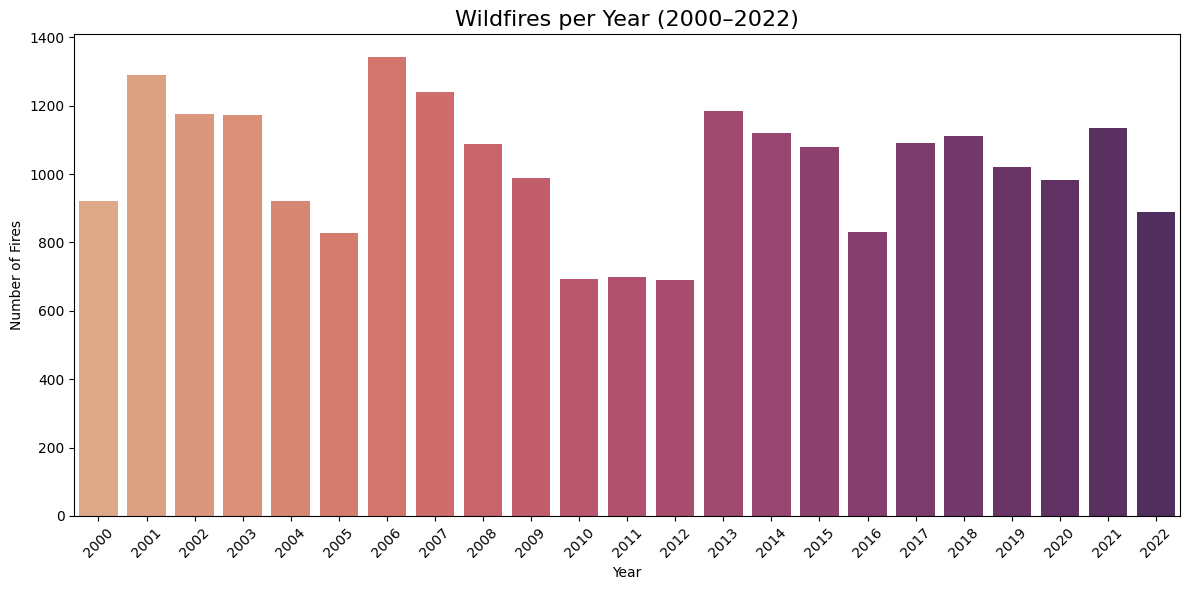

In [9]:
# Ensure FireYear is integer
df['FireYear'] = pd.to_numeric(df['FireYear'], errors='coerce')
fires_per_year = df['FireYear'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
sns.barplot(x=fires_per_year.index, y=fires_per_year.values, palette="flare")
plt.title('Wildfires per Year (2000–2022)', fontsize=16)
plt.xlabel('Year')
plt.ylabel('Number of Fires')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

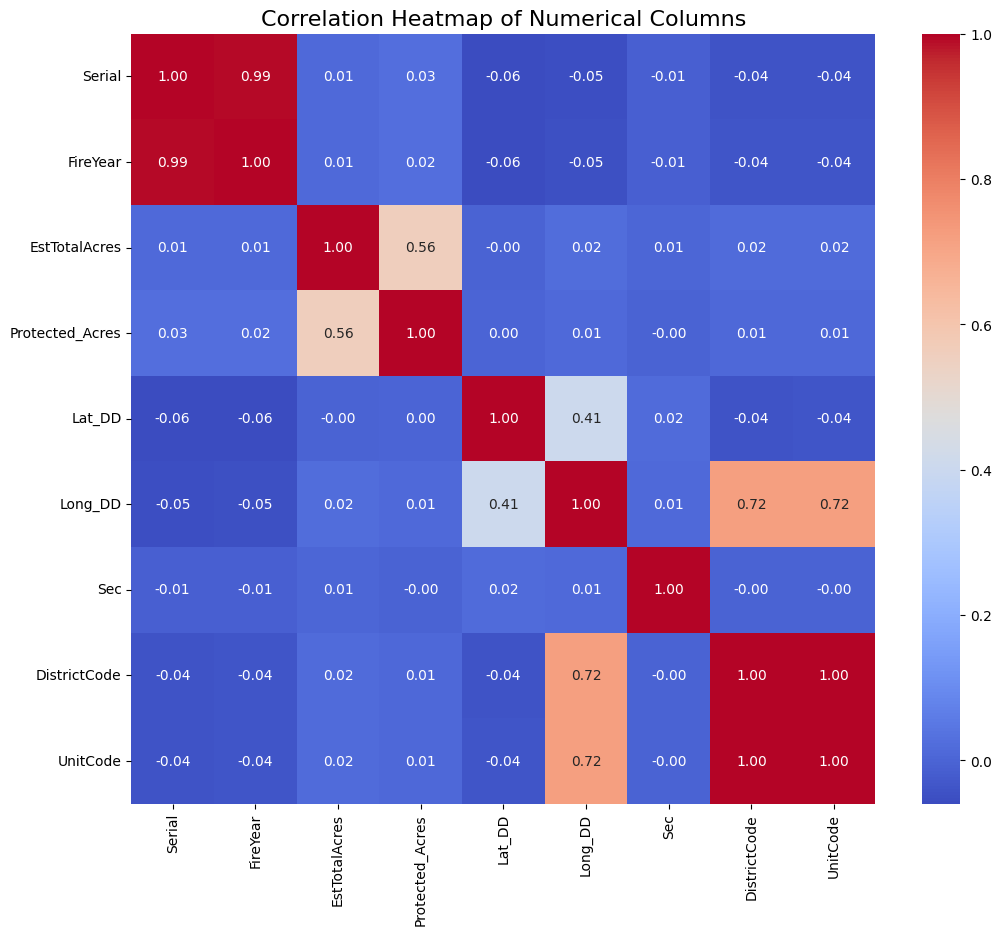

In [10]:
# Select only numerical columns for correlation analysis
numerical_cols = df.select_dtypes(include=np.number).columns
df_numerical = df[numerical_cols]

# Calculate the correlation matrix
correlation_matrix = df_numerical.corr()

# Plot the correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numerical Columns', fontsize=16)
plt.show()

In [11]:
# Load dataset
df = pd.read_csv("/content/ODF_Fire_Occurrence_Data_2000-2022.csv")

In [12]:
from sklearn.preprocessing import LabelEncoder

In [13]:
import pandas as pd

# Automatically get the file name from uploaded
file_name = list(uploaded.keys())[0]
df = pd.read_csv("ODF_Fire_Occurrence_Data_2000-2022.csv")

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder

# Load dataset
df = pd.read_csv("/content/ODF_Fire_Occurrence_Data_2000-2022.csv")

# Drop rows with missing key values
df = df.dropna(subset=['GeneralCause', 'Lat_DD', 'Long_DD', 'Size_class'])

# Encode categorical target (FireCause)
le = LabelEncoder()
df['FireCauseEncoded'] = le.fit_transform(df['GeneralCause'])

# Feature engineering (you can improve this based on available data)
features = df[['Lat_DD', 'Long_DD', 'Size_class']]
target = df['FireCauseEncoded']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [15]:
df['Size_class_encoded'] = LabelEncoder().fit_transform(df['Size_class'])
features = df[['Lat_DD', 'Long_DD', 'Size_class_encoded']]


In [32]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42
)


In [33]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

search = RandomizedSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='accuracy', n_iter=5)
search.fit(X_train, y_train)
print("Best accuracy:", search.best_score_)
print("Best parameters:", search.best_params_)


Best accuracy: 0.6312245300366027
Best parameters: {'n_estimators': 300, 'min_samples_split': 5, 'max_depth': 20}


In [30]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=20,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='mlogloss',
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.6120966018379995


In [39]:
pip install imbalanced-learn


In [40]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Train with XGBoost on balanced data
xgb_model.fit(X_resampled, y_resampled)
y_pred = xgb_model.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.5753366103868348
              precision    recall  f1-score   support

           0       0.20      0.33      0.25       166
           1       0.66      0.61      0.64       854
           2       0.52      0.37      0.43       958
           3       0.10      0.22      0.14       117
           4       1.00      1.00      1.00      1278
           5       0.28      0.22      0.24       454
           6       0.15      0.42      0.23        26
           7       0.53      0.51      0.52       610
           8       0.12      0.17      0.14       197
           9       0.06      0.32      0.10        19

    accuracy                           0.58      4679
   macro avg       0.36      0.42      0.37      4679
weighted avg       0.61      0.58      0.59      4679



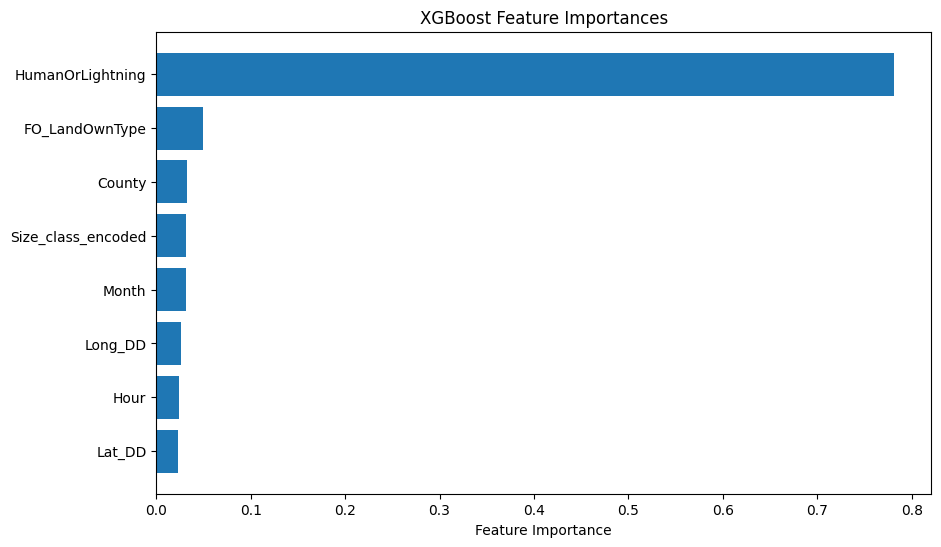

In [41]:
import matplotlib.pyplot as plt
import numpy as np

importances = xgb_model.feature_importances_
feature_names = X_train.columns
indices = np.argsort(importances)

plt.figure(figsize=(10, 6))
plt.barh(np.array(feature_names)[indices], importances[indices])
plt.xlabel("Feature Importance")
plt.title("XGBoost Feature Importances")
plt.show()


<Figure size 1200x800 with 0 Axes>

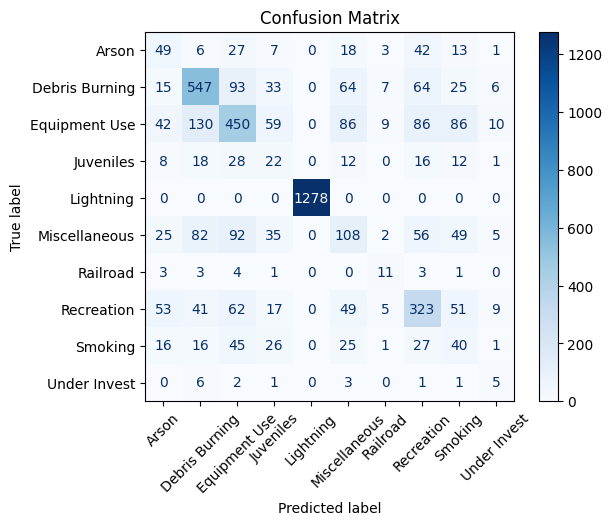

In [51]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Optional: class labels (decoded from FireCauseEncoded if you want readable labels)
class_names = le_cause.classes_  # This uses label encoder from preprocessing

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the matrix
plt.figure(figsize=(12, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()


In [42]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore")

# Load dataset
df = pd.read_csv("/content/ODF_Fire_Occurrence_Data_2000-2022.csv")

# Drop rows with missing key values
df = df.dropna(subset=[
    'GeneralCause', 'Lat_DD', 'Long_DD', 'Size_class',
    'Ign_DateTime', 'HumanOrLightning', 'County', 'FO_LandOwnType'
])

# Encode categorical target
df['FireCauseEncoded'] = LabelEncoder().fit_transform(df['GeneralCause'])

# Encode size class
df['Size_class_encoded'] = LabelEncoder().fit_transform(df['Size_class'])

# Parse Ignition datetime
df['Ign_DateTime'] = pd.to_datetime(df['Ign_DateTime'], errors='coerce')
df['Month'] = df['Ign_DateTime'].dt.month
df['Hour'] = df['Ign_DateTime'].dt.hour

# Encode categorical features
for col in ['HumanOrLightning', 'County', 'FO_LandOwnType']:
    df[col] = LabelEncoder().fit_transform(df[col])

# Features and target
features = df[['Lat_DD', 'Long_DD', 'Size_class_encoded', 'Month', 'Hour',
               'HumanOrLightning', 'County', 'FO_LandOwnType']]
target = df['FireCauseEncoded']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42
)

# Apply SMOTE to balance classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# XGBoost with tuned parameters
xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=10,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='mlogloss',
    n_jobs=-1,
    random_state=42
)

# Train model
xgb_model.fit(X_resampled, y_resampled)

# Predict and evaluate
y_pred = xgb_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.5753366103868348

Classification Report:
               precision    recall  f1-score   support

           0       0.20      0.33      0.25       166
           1       0.66      0.61      0.64       854
           2       0.52      0.37      0.43       958
           3       0.10      0.22      0.14       117
           4       1.00      1.00      1.00      1278
           5       0.28      0.22      0.24       454
           6       0.15      0.42      0.23        26
           7       0.53      0.51      0.52       610
           8       0.12      0.17      0.14       197
           9       0.06      0.32      0.10        19

    accuracy                           0.58      4679
   macro avg       0.36      0.42      0.37      4679
weighted avg       0.61      0.58      0.59      4679



In [50]:
# ----------------------------------------
# STEP 3: Train on CPU - RandomForest
# ----------------------------------------
import time
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")


# --- Data Loading and Preprocessing (Copied and adapted from previous cells) ---
# Load dataset
df = pd.read_csv("/content/ODF_Fire_Occurrence_Data_2000-2022.csv")

# Drop rows with missing key values for the columns used in features and target
df = df.dropna(subset=[
    'GeneralCause', 'Lat_DD', 'Long_DD', 'Size_class',
    'Ign_DateTime', 'HumanOrLightning', 'County', 'FO_LandOwnType'
])

# Encode categorical target
df['FireCauseEncoded'] = LabelEncoder().fit_transform(df['GeneralCause'])

# Encode size class
df['Size_class_encoded'] = LabelEncoder().fit_transform(df['Size_class'])

# Parse Ignition datetime
df['Ign_DateTime'] = pd.to_datetime(df['Ign_DateTime'], errors='coerce')
df['Month'] = df['Ign_DateTime'].dt.month
df['Hour'] = df['Ign_DateTime'].dt.hour

# Encode categorical features
for col in ['HumanOrLightning', 'County', 'FO_LandOwnType']:
    df[col] = LabelEncoder().fit_transform(df[col])

# Features and target
features = df[['Lat_DD', 'Long_DD', 'Size_class_encoded', 'Month', 'Hour',
               'HumanOrLightning', 'County', 'FO_LandOwnType']]
target = df['FireCauseEncoded']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42
)
# --- End Data Loading and Preprocessing ---


start_cpu = time.time()
# Using parameters from the randomized search for potentially better performance
rf_model = RandomForestClassifier(n_estimators=200, max_depth=20, min_samples_split=5, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
end_cpu = time.time()

cpu_accuracy = accuracy_score(y_test, rf_pred)
cpu_time = end_cpu - start_cpu

print(f"CPU Training Time: {cpu_time:.4f} seconds")
print(f"CPU Accuracy: {cpu_accuracy:.4f}")

CPU Training Time: 4.3666 seconds
CPU Accuracy: 0.6362


In [44]:
print(f" RandomForest CPU Accuracy: {cpu_accuracy:.4f}")
print(f" RandomForest CPU Training Time: {cpu_time:.2f} seconds")

 RandomForest CPU Accuracy: 0.6362
 RandomForest CPU Training Time: 3.82 seconds


In [45]:
# ----------------------------------------
# STEP 4: Train on GPU - XGBoost
# ----------------------------------------
xgb_gpu = XGBClassifier(
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    n_estimators=100,
    max_depth=20,
    learning_rate=0.1,
    random_state=42,
    eval_metric='mlogloss',
    use_label_encoder=False
)

start_gpu = time.time()
xgb_gpu.fit(X_train, y_train)
y_pred_gpu = xgb_gpu.predict(X_test)
end_gpu = time.time()

gpu_accuracy = accuracy_score(y_test, y_pred_gpu)
gpu_time = end_gpu - start_gpu


In [46]:
print(f" XGBoost GPU Accuracy: {gpu_accuracy:.4f}")
print(f" XGBoost GPU Training Time: {gpu_time:.2f} seconds")

 XGBoost GPU Accuracy: 0.6149
 XGBoost GPU Training Time: 8.49 seconds


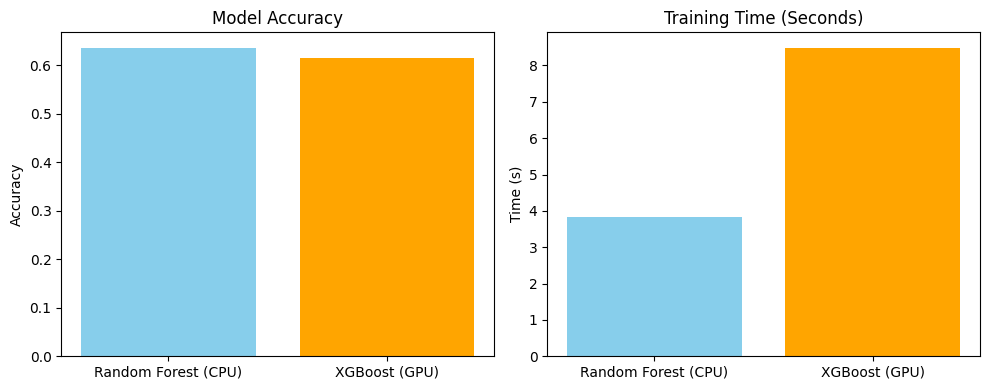

In [47]:
# ----------------------------------------
# STEP 5: Show Comparison Charts
# ----------------------------------------
labels = ['Random Forest (CPU)', 'XGBoost (GPU)']
accuracies = [cpu_accuracy, gpu_accuracy]
times = [cpu_time, gpu_time]

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.bar(labels, accuracies, color=['skyblue', 'orange'])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")

plt.subplot(1, 2, 2)
plt.bar(labels, times, color=['skyblue', 'orange'])
plt.title("Training Time (Seconds)")
plt.ylabel("Time (s)")

plt.tight_layout()
plt.show()
